# Titanic 호 data 를 이용한 EDA 와 Feature Engineering Project

- Titanic 호 승객의 생존 여부 예측

### Titanic data columns

Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)  $\rightarrow$ 객실 등급  
survival -  Survival (0 = 사망; 1 = 생존)  $\rightarrow$ 생존여부  
name - Name  
sex - Sex  
age - Age  
sibsp - Number of Siblings/Spouses Aboard  $\rightarrow$ 함께 탑승한 형제 또는 배우자 수   
parch - Number of Parents/Children Aboard  $\rightarrow$ 함께 탑승한 부모 또는 자녀 수  
ticket - Ticket Number  
fare - Passenger Fare (British pound)  
cabin - Cabin  $\rightarrow$ 선실번호  
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)  $\rightarrow$ 탑승한 항구(얼마나 부유한지와 관련)

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (4, 3)
plt.style.use('seaborn')
np.random.seed(141)

## EDA (Exploratory Data Analysis) and Data Wrangling

In [2]:
df = pd.read_csv("data/titanic.csv")
df.shape

(891, 12)

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### categorical feature 의 분포 파악

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


중복된 이름은 없고, 성별은 2 가지, 출발 항구는 3 군데임을 알 수 있습니다.

### 각 field 의 null value 유무 check

In [6]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age 가 결측치 많으므로 채워줄 필요 있음. Cabin에 결측치가 많은 이유는 선실 없이 탑승한 사람이 많은 것으로 추측됨.

### 생존자 수 파악

### pie chart 이용
- `explode`는 부채꼴이 파이 차트의 중심에서 벗어나는 정도를 설정
- `autopct`는 부채꼴 안에 표시될 숫자의 형식을 지정

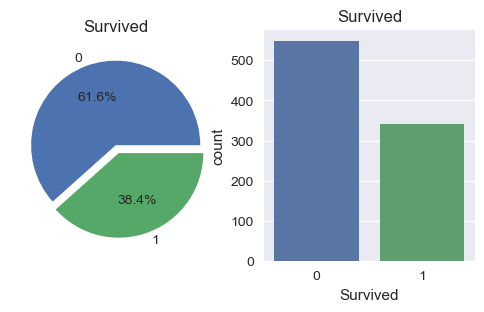

In [7]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

df['Survived'].value_counts() \
    .plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax1)

ax1.set_title('Survived')
ax1.set_ylabel('')
sns.countplot(x='Survived', data=df, ax=ax2)
ax2.set_title('Survived')
plt.show()

- 38.4 % 가 생존 (사망 - 0, 생존 - 1) 했음

## Feature type 별 분석
### Categorical features (Nominal Variable, 범주형 변수)
- Sex, Embarked

### Ordinal features (순위 변수)
- PClass

### Continuous feature (연속 변수)
- Age, Parch, Fare

### Discrete feature (이산 변수)
- SibSip

### Sex $\rightarrow$ Categoruical feature  

- 성별이 생존 여부와 상관관계가 있는지 분석

In [8]:
pd.crosstab(df['Survived'], df['Sex'])

Sex,female,male
Survived,,
0,81,468
1,233,109


<AxesSubplot:xlabel='Survived', ylabel='count'>

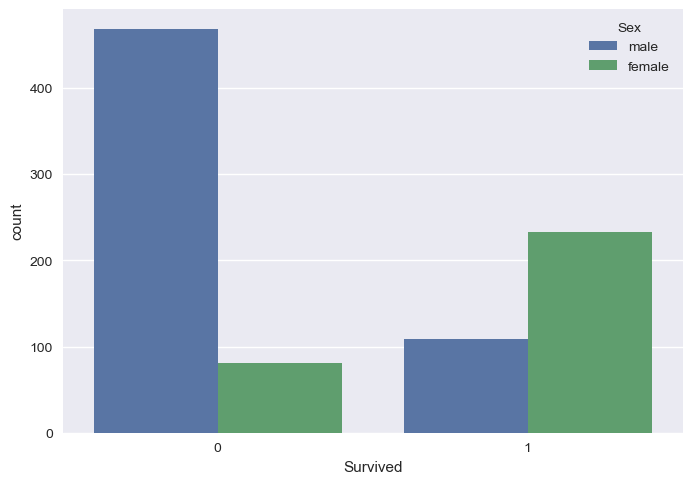

In [9]:
sns.countplot(x="Survived", hue="Sex", data=df)

- 여성의 생존 비율이 높으므로 성별은 생존 여부 판단에 매우 중요한 feature 임

### Pclass $\rightarrow$ Ordinal feature  

- Pclass(객실 등급)과 생존 여부의 상관 관계 분석

In [10]:
pd.crosstab(df['Pclass'], df['Survived'])

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


<AxesSubplot:xlabel='Pclass', ylabel='count'>

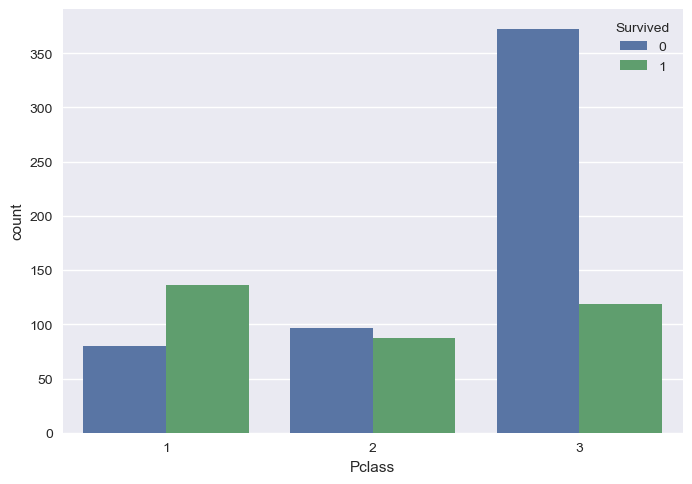

In [11]:
sns.countplot(x='Pclass',  hue='Survived', data=df)

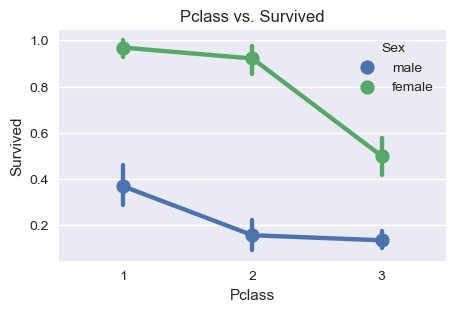

In [12]:
sns.pointplot(x='Pclass', y="Survived", hue="Sex", data=df)
plt.title('Pclass vs. Survived')
fig = plt.gcf()
fig.set_size_inches(5, 3)

- Pclass(객실 등급)이 높을 수록 생존율의 기대치가 높은 것으로 보이므로 Pclass column 은 생존 여부 판단의 중요한 변수이고, ordinal feature 로 유지한다.

### Age $\rightarrow$ Continuous feature

- 나이과 생존 여부의 상관 관계 분석

In [13]:
print('최고령 - {}'.format(df['Age'].max()))
print('최연소 - {}'.format(df['Age'].min()))
print('평균 연령 - {:.2f}'.format(df['Age'].mean()))

최고령 - 80.0
최연소 - 0.42
평균 연령 - 29.70


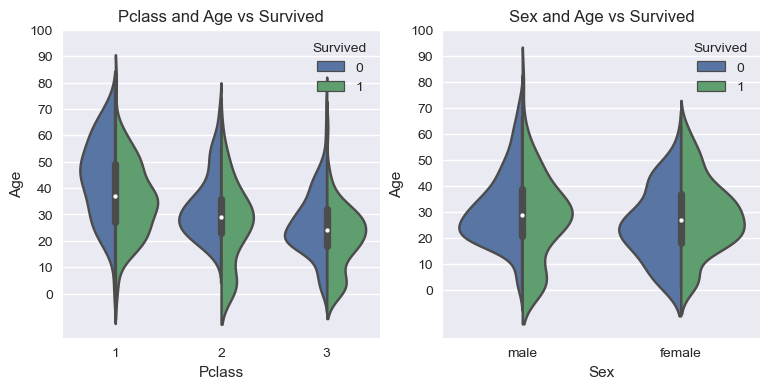

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

sns.violinplot(x='Pclass', y='Age', hue='Survived', data=df, split=True, ax=ax1)
ax1.set_title('Pclass and Age vs Survived')
ax1.set_yticks(range(0, 110, 10))

sns.violinplot(x='Sex', y='Age', hue='Survived', data=df, split=True, ax=ax2)
ax2.set_title('Sex and Age vs Survived')
ax2.set_yticks(range(0, 110, 10));

- 객실 등급과 성별에 따라 연령 분포가 다르므로 `Age`는 생존 여부를 판단하기 좋은 특성으로 판단

### Embarked $\rightarrow$ Categoruical feature  

- 출발 항구와 생존 여부의 상관 관계 분석 

In [15]:
pd.crosstab(df.Embarked, df.Survived, margins=True)

Survived,0,1,All
Embarked,,,
C,75,93,168
Q,47,30,77
S,427,217,644
All,549,340,889


<AxesSubplot:xlabel='Embarked', ylabel='count'>

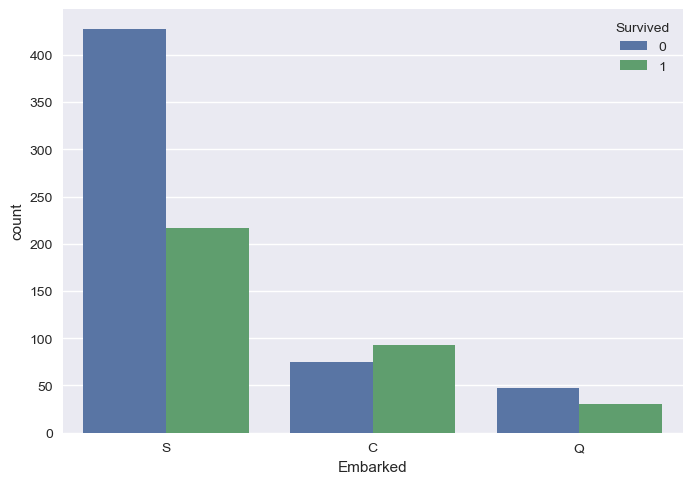

In [16]:
sns.countplot(x='Embarked', hue="Survived", data=df)

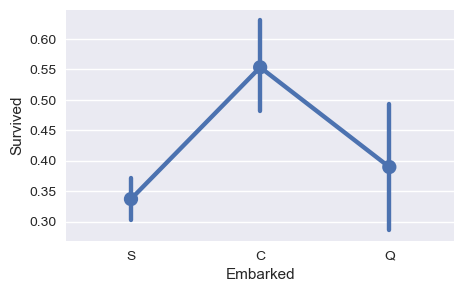

In [17]:
sns.pointplot(x="Embarked", y="Survived", data=df)
fig = plt.gcf()
fig.set_size_inches(5, 3)

- C 항구에서 탑승한 승객의 생존 추정값이 높으므로 `Embarked`는 생존 여부 예측의 좋은 feature 일 가능성 높음

- 탑승 승객 대비 생존자 수 비율이 C 항구가 가장 높음을 알 수 있다.

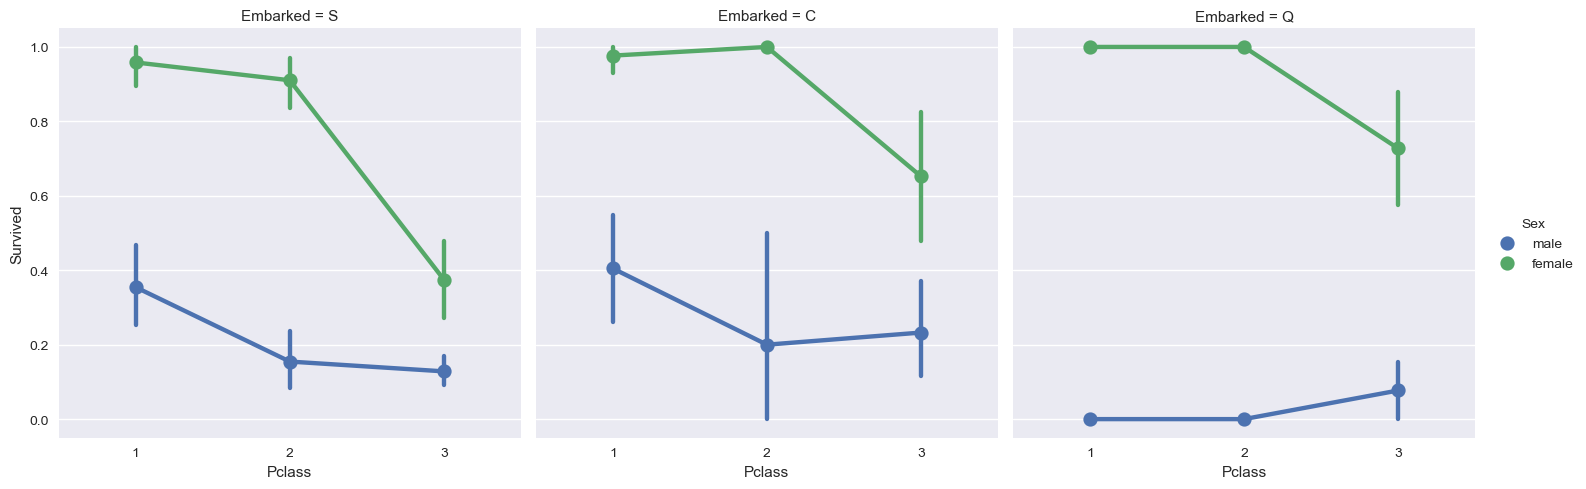

In [18]:
sns.catplot(x="Pclass", y="Survived", hue="Sex", col="Embarked", data=df, kind="point")

- C 항구에서 탑승한 사람들의 생존 비율이 남녀 공히 높게 나타난다.  
- 모든 항구에서 여성의 생존 예측값이 남성 보다 높게 나타난다.  
- 따라서, 출항 항구도 생존 여부 예측에 좋은 feature 로 판단된다.

### SibSp $\rightarrow$ Discrete feature

- SibSp 와 생존 여부의 상관 관계 분석

In [19]:
pd.crosstab(df.SibSp, df.Survived, margins=True)

Survived,0,1,All
SibSp,,,
0,398,210,608
1,97,112,209
2,15,13,28
3,12,4,16
4,15,3,18
5,5,0,5
8,7,0,7
All,549,342,891


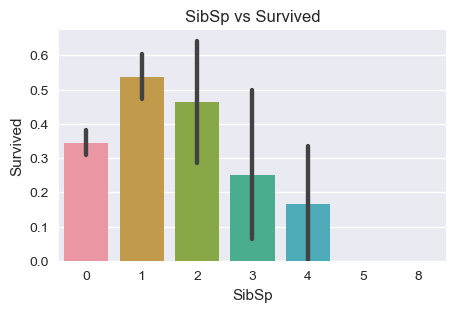

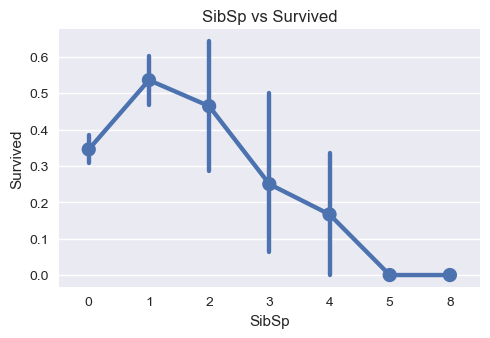

In [20]:
sns.barplot(x='SibSp', y='Survived', data=df)
plt.title('SibSp vs Survived')
fig = plt.gcf()
fig.set_size_inches(5,3)

sns.catplot(x='SibSp', y='Survived', data=df, kind='point')
plt.title('SibSp vs Survived')
fig = plt.gcf()
fig.set_size_inches(5,3)

- SibSp가 1 or 2인 경우 생존율이 높으므로 SibSp는 생존 여부의 상관 관계가 있는 feature로 보인다.

### Parch : Discrete Feature

- Parent Child 가 함께 승선한 자녀수

- Parch 와 Survival의 관계 분석

In [21]:
pd.crosstab(df.Parch, df.Survived)

Survived,0,1
Parch,,
0,445,233
1,53,65
2,40,40
3,2,3
4,4,0
5,4,1
6,1,0


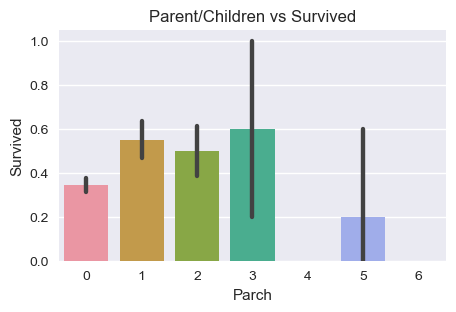

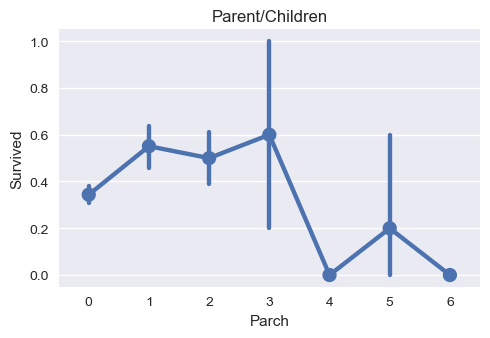

In [22]:
sns.barplot(x='Parch', y='Survived', data=df)
plt.title('Parent/Children vs Survived')
fig = plt.gcf()
fig.set_size_inches(5, 3)

sns.catplot(x='Parch', y='Survived', data=df, kind='point')
plt.title('Parent/Children')
fig = plt.gcf()
fig.set_size_inches(5, 3)

- 자녀수 1~3 의 생존율이 0 인 경우보다 높으므로, 생존 여부 예측에 도움되는 feature로 판단.

### Fare $\rightarrow$ Continuous feature

- Fare와 Pclass의 관계 분석

In [23]:
print('최고가:',df['Fare'].max())
print('최저가:',df['Fare'].min())
print('평균:',df['Fare'].mean())

최고가: 512.3292
최저가: 0.0
평균: 32.2042079685746


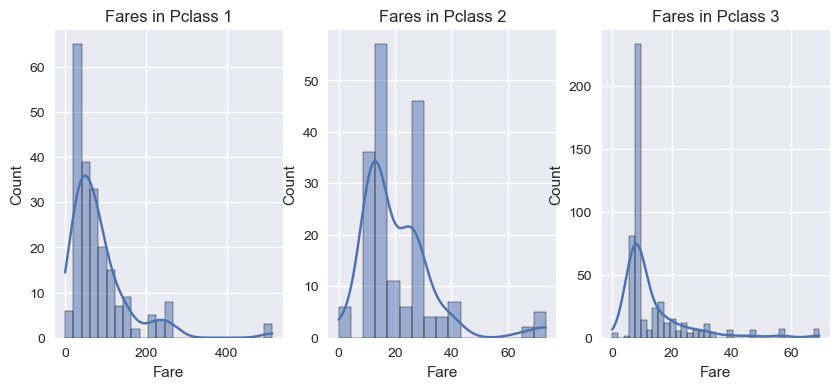

In [24]:
fig, ax = plt.subplots(1,3,figsize=(10,4))
sns.histplot(x=df[df['Pclass']==1].Fare,ax=ax[0], kde=True)
ax[0].set_title('Fares in Pclass 1')
sns.histplot(x=df[df['Pclass']==2].Fare,ax=ax[1], kde=True)
ax[1].set_title('Fares in Pclass 2')
sns.histplot(x=df[df['Pclass']==3].Fare,ax=ax[2], kde=True)
ax[2].set_title('Fares in Pclass 3');

- Pclass 와 Fare 간의 뚜렷한 상관 관계가 보임. Pclass 값이 작을 수록 Fare가 높다.  

- Fare 도 생존 여부 예측에 좋은 feature 로 판단.

### Parch : Discrete Feature

- Parent Child 가 함께 승선한 자녀수

- Parch 와 Survival의 관계 분석

In [25]:
pd.crosstab(df.Parch, df.Survived)

Survived,0,1
Parch,,
0,445,233
1,53,65
2,40,40
3,2,3
4,4,0
5,4,1
6,1,0


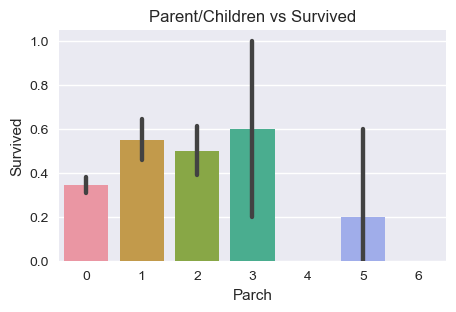

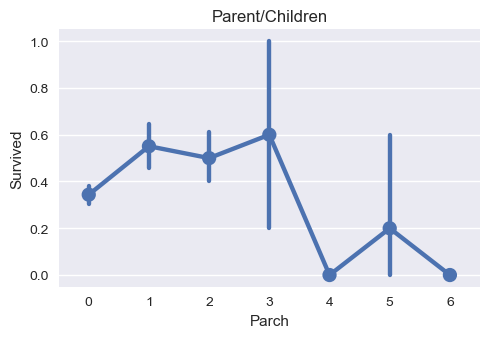

In [26]:
sns.barplot(x='Parch', y='Survived', data=df)
plt.title('Parent/Children vs Survived')
fig = plt.gcf()
fig.set_size_inches(5, 3)

sns.catplot(x='Parch', y='Survived', data=df, kind='point')
plt.title('Parent/Children')
fig = plt.gcf()
fig.set_size_inches(5, 3)

- 자녀수 1~3 의 생존율이 0 인 경우보다 높으므로, 생존 여부 예측에 도움되는 feature로 판단.

## Missing Value 처리

In [27]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Age missing value 처리

- Name 안의 정보를 추출하여 연령대를 추측 : Domain 지식 활용  

- 승객명 안의 호칭(Mr., Mrs., Master 등)으로 성별과 직업을 추측 가능

In [28]:
df.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

- regular expression 을 이용하여 `.`으로 끝나는 이름 중 호칭 부분 추출하여 `initial` column으로 저장

In [29]:
df.Name.str.extract('([A-Za-z]+)\.')

,0
0,Mr
1,Mrs
2,Miss
3,Mrs
4,Mr
...,...
886,Rev
887,Miss
888,Miss
889,Mr


In [30]:
# 이름의 initial 추출
df['Initial'] = df.Name.str.extract('([A-Za-z]+)\.')

In [31]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss


In [32]:
pd.crosstab(df.Initial, df.Sex).T

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- `Mr`, `Miss`, `Mrs`, `Master`, `Others` 로 범주화 한 후 category별 평균 나이 계산하여 Age 의 null value 채움

In [33]:
df.loc[(df.Initial != 'Mr') & (df.Initial != 'Mrs') &  (df.Initial != 'Miss'), 'Initial'] = 'Others'
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,Others
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,Mr
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,Mr


In [34]:
df.groupby('Initial')['Age'].mean()

Initial
Miss      21.773973
Mr        32.368090
Mrs       35.898148
Others    20.430161
Name: Age, dtype: float64

- Age 가 missing 된 row 들은 Initial 에 따라 값을 채우준다.

In [35]:
df.loc[(df.Age.isnull()) & (df.Initial == 'Mr'), 'Age'] = 32
df.loc[(df.Age.isnull()) & (df.Initial == 'Mrs'), 'Age'] = 36
df.loc[(df.Age.isnull()) & (df.Initial == 'Miss'), 'Age'] = 22
df.loc[(df.Age.isnull()) & (df.Initial == 'Others'), 'Age'] = 20

In [36]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Initial          0
dtype: int64

### Embarked null 처리
- 'S' 에서 승선한 사람이 가장 많으므로 Embarked 의 null 을 'S' 로 채움

In [37]:
df['Embarked'].fillna('S', inplace=True)

### 선실 번호(`Cabin`)는 생존 여부 예측에 불필요 하고 missing value 많으므로 삭제.

In [38]:
df.drop('Cabin', axis=1, inplace=True)

In [39]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Initial        0
dtype: int64

## outlier 검출

- outlier 가 prediction(특히 regression) 에 영향을 큰 영향을 줄 수 있으므로, 연속값으로 구성된 column 의 outlier 검출

- outlier 의 정의는 일반적으로 IQR(Inter-quartile range, Q3 - Q1) * 1.5 보다 큰 경우로 한다.

-  세개 이상의 outlier 값을 가진 row 를 drop 시킨다.

- outlier 검출 대상은 `Age`, `Parch`, `SibSp`, `Fare` 로 하고, 시각화 하여 value range 확인

(891, 12)

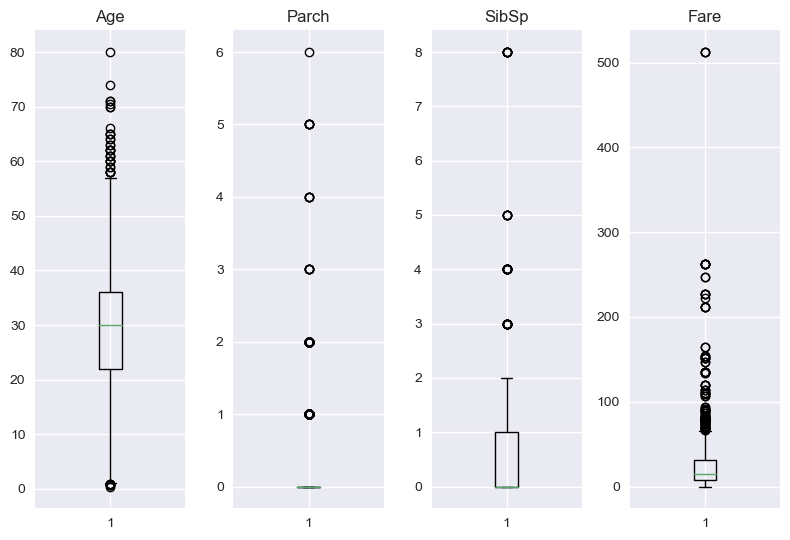

In [40]:
plt.subplot(141)
plt.boxplot(df['Age'])
plt.title('Age')

plt.subplot(142)
plt.boxplot(df['Parch'])
plt.title('Parch')

plt.subplot(143)
plt.boxplot(df['SibSp'])
plt.title('SibSp')

plt.subplot(144)
plt.boxplot(df['Fare'])
plt.title('Fare')
plt.tight_layout()
df.shape

In [41]:
outlier_indices = []

for col in ['Age', 'SibSp', 'Parch', 'Fare']:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1   
    outlier_step = IQR * 1.5
    outlier_list = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
    outlier_indices.extend(outlier_list)

In [42]:
# outlier 로 보이는 값을 가진 row 의 index

len(outlier_indices), outlier_indices[:10]

(415, [11, 33, 54, 78, 94, 96, 116, 170, 195, 232])

In [43]:
Counter(outlier_indices).items()

dict_items([(11, 1), (33, 1), (54, 2), (78, 2), (94, 1), (96, 1), (116, 1), (170, 1), (195, 2), (232, 1), (252, 1), (268, 3), (275, 2), (280, 1), (305, 3), (326, 1), (366, 2), (438, 3), (456, 1), (469, 2), (483, 1), (487, 1), (493, 1), (545, 1), (555, 1), (570, 1), (587, 3), (625, 1), (630, 1), (644, 2), (659, 3), (672, 1), (684, 2), (694, 1), (745, 3), (755, 2), (803, 2), (829, 2), (831, 2), (851, 1), (7, 2), (16, 2), (24, 2), (27, 3), (50, 2), (59, 2), (63, 2), (68, 2), (71, 2), (85, 1), (88, 3), (119, 2), (159, 3), (164, 2), (171, 2), (176, 2), (180, 3), (182, 2), (201, 3), (229, 2), (233, 2), (261, 2), (266, 2), (278, 2), (324, 3), (341, 3), (374, 2), (386, 2), (409, 2), (480, 2), (485, 2), (541, 2), (542, 2), (634, 2), (642, 2), (683, 2), (686, 2), (726, 1), (787, 2), (792, 3), (813, 2), (819, 2), (824, 2), (846, 3), (850, 2), (863, 3), (8, 1), (10, 1), (13, 1), (25, 1), (43, 1), (58, 1), (65, 1), (86, 1), (93, 1), (97, 1), (98, 1), (102, 2), (118, 2), (124, 2), (128, 1), (136, 1)

In [44]:
# outlier 를 THRESHOLD 개 이상 가진 row 의 index

THRESHOLD_OUTLIER = 3

multiple_outliers = [k for k, v in Counter(outlier_indices).items() if v >= THRESHOLD_OUTLIER]

multiple_outliers

[268, 305, 438, 587, 659, 745, 27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

- 이상치 의심 데이터를 육안으로 확인

In [45]:
df.loc[multiple_outliers, ['Age', 'SibSp', 'Parch', 'Fare']]

,Age,SibSp,Parch,Fare
268,58.00,0,1,153.4625
305,0.92,1,2,151.5500
438,64.00,1,4,263.0000
587,60.00,1,1,79.2000
659,58.00,0,2,113.2750
745,70.00,1,1,71.0000
27,19.00,3,2,263.0000
88,23.00,3,2,263.0000
159,20.00,8,2,69.5500
180,22.00,8,2,69.5500


In [46]:
df.loc[multiple_outliers]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial
268,269,1,1,"Graham, Mrs. William Thompson (Edith Junkins)",female,58.00,0,1,PC 17582,153.4625,S,Mrs
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,S,Others
438,439,0,1,"Fortune, Mr. Mark",male,64.00,1,4,19950,263.0000,S,Mr
587,588,1,1,"Frolicher-Stehli, Mr. Maxmillian",male,60.00,1,1,13567,79.2000,C,Mr
659,660,0,1,"Newell, Mr. Arthur Webster",male,58.00,0,2,35273,113.2750,C,Mr
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.00,1,1,WE/P 5735,71.0000,S,Others
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,S,Mr
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,S,Miss
159,160,0,3,"Sage, Master. Thomas Henry",male,20.00,8,2,CA. 2343,69.5500,S,Others
180,181,0,3,"Sage, Miss. Constance Gladys",female,22.00,8,2,CA. 2343,69.5500,S,Miss


Domain 지식을 활용하여 검토한 결과 index id 745를 최종 삭제하기로 결정

In [47]:
df = df.drop(745).reset_index(drop=True)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  890 non-null    int64  
 1   Survived     890 non-null    int64  
 2   Pclass       890 non-null    int64  
 3   Name         890 non-null    object 
 4   Sex          890 non-null    object 
 5   Age          890 non-null    float64
 6   SibSp        890 non-null    int64  
 7   Parch        890 non-null    int64  
 8   Ticket       890 non-null    object 
 9   Fare         890 non-null    float64
 10  Embarked     890 non-null    object 
 11  Initial      890 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Machine Learning 을 위한 Feature Engineering
### Age 
- Age 가 연속변수 이므로 Machine Learning 을 위해 binning 혹은 normalization 을 통해 categorical value 로 convert   
- `pd.cut` 함수를 이용하여 bandwidth가 동일한 5 개의 bin으로 구분.

In [49]:
bandwidth = (max(df['Age'] - min(df['Age']))) / 5
bandwidth

15.916

In [50]:
bins = np.arange(min(df['Age']), max(df['Age']), bandwidth)
bins

array([ 0.42 , 16.336, 32.252, 48.168, 64.084])

In [51]:
df['Age_band'] = 0

df.loc[df.Age <= 16, 'Age_band'] = 0
df.loc[(df.Age > 16) & (df.Age <= 32), 'Age_band'] = 1
df.loc[(df.Age > 32) & (df.Age <= 48), 'Age_band'] = 2
df.loc[(df.Age > 48) & (df.Age <= 64), 'Age_band'] = 3
df.loc[df.Age > 64, 'Age_band'] = 4
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,2


### Family_Size 변수 
- Parch + SibSp 로 새로운 Family_Size 변수 생성

### Alone 변수
- Family_Size 가 0 면 Alone 변수에 1 assign

In [52]:
df['Family_size'] = df.Parch + df.SibSp
df['Alone'] = 0

df.loc[df.Family_size == 0, 'Alone'] = 1
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial,Age_band,Family_size,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,2,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,2,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,2,0,1


- 혼자 탑승한 경우의 생존 여부를 성별, Pclass 별로 구분하여 시각화

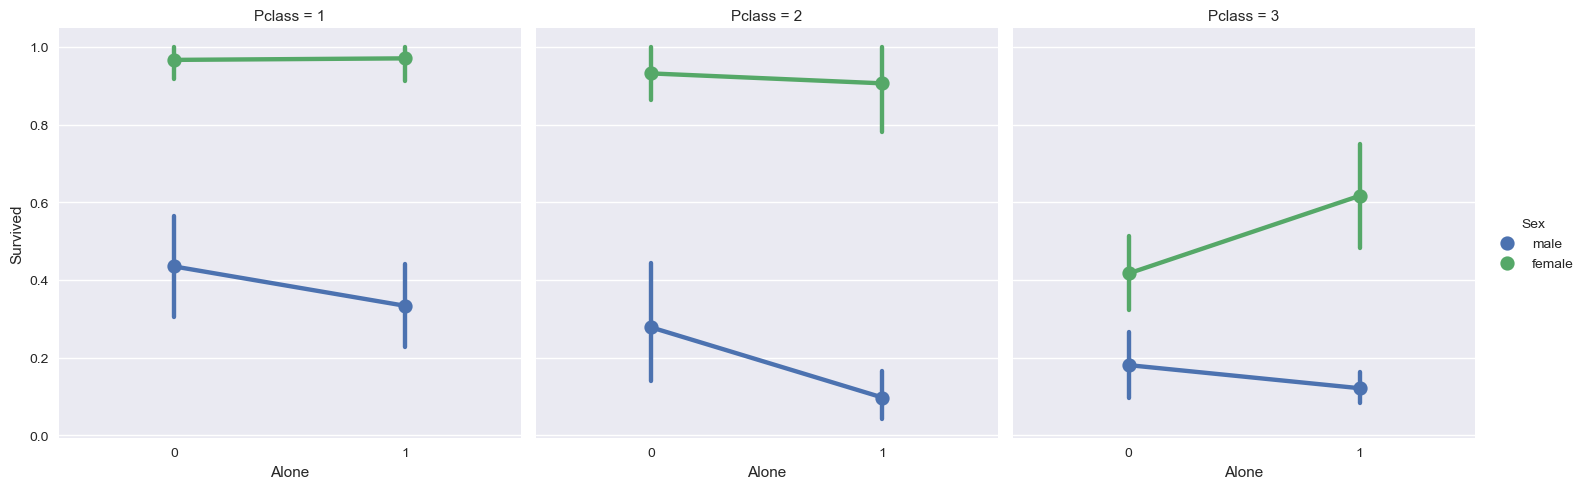

In [53]:
sns.catplot(x='Alone', y='Survived', hue='Sex', col='Pclass', data=df, kind='point')

- 1, 2 등실은 여성의 경우 혼자 탑승(`Alone=1`) 여부에 무관하게 생존율이 비슷하지만, 3등실의 여성은 가족과 함께 탑승한 여성보다 혼자 탑승한 경우생존율이 높은 것이 보이므로 `Alone`은 생존 예측에 도움되는 feature 로 보인다.

### Fare_Range Binning
- Fare 역시 연속변수 이므로 pandas.qcut 함수를 이용하여 category 변수로 convert

In [54]:
# 4분위수로 구간 나누기
df['Fare_Range'] = pd.qcut(df.Fare, 4)  
df.groupby('Fare_Range').Survived.mean().to_frame()

,Survived
Fare_Range,
"(-0.001, 7.903]",0.197309
"(7.903, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.583710


In [55]:
df['Fare_cat'] = 0

df.loc[df.Fare <= 7.91, 'Fare_cat'] = 0
df.loc[(df.Fare > 7.91) & (df.Fare <= 14.454), 'Fare_cat'] = 1
df.loc[(df.Fare > 14.454) & (df.Fare <= 31), 'Fare_cat'] = 2
df.loc[(df.Fare > 31) & (df.Age <= 513), 'Fare_cat'] = 3
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial,Age_band,Family_size,Alone,Fare_Range,Fare_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1,1,0,"(-0.001, 7.903]",0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,2,1,0,"(31.0, 512.329]",3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,1,0,1,"(7.903, 14.454]",1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,2,1,0,"(31.0, 512.329]",3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,2,0,1,"(7.903, 14.454]",1


- Fare 대비 생존율을 성별로 구분하여 plot

<AxesSubplot:xlabel='Fare_cat', ylabel='Survived'>

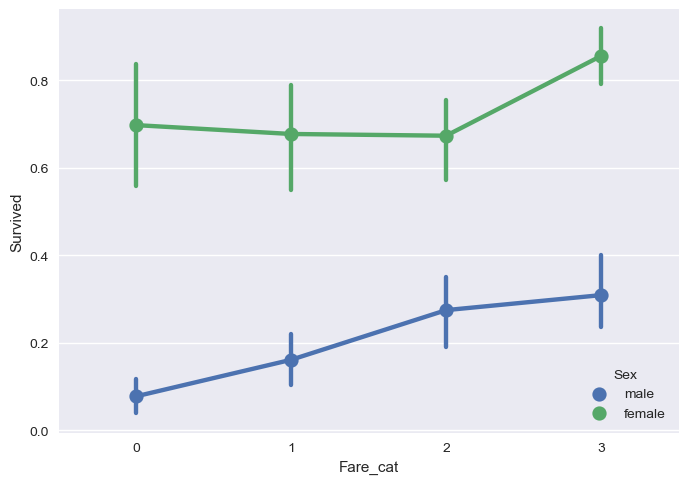

In [56]:
sns.pointplot(x='Fare_cat', y='Survived', data=df, hue='Sex')

- 가격대별로 생존 예측값이 차이나고, 특히 남성 승객의 경우 크게 차이 있으므로 생존 여부 예측에 도움될 것으로 보인다.

### 불필요한 field drop

- `Age -> Age_band`, `Fare/Fare_Rage -> Fare_cat` 으로 구간화 하였으므로 drop 

In [57]:
df.drop(['Name', 'Age', 'Ticket', 'Fare', 'Fare_Range', 'PassengerId'], axis=1, inplace=True)

In [58]:
df.head(3)

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Initial,Age_band,Family_size,Alone,Fare_cat
0,0,3,male,1,0,S,Mr,1,1,0,0
1,1,1,female,1,0,C,Mrs,2,1,0,3
2,1,3,female,0,0,S,Miss,1,0,1,1


## Feature 들 간의 Correlation

- Survived 와 각 Feature 간 상관관계 파악

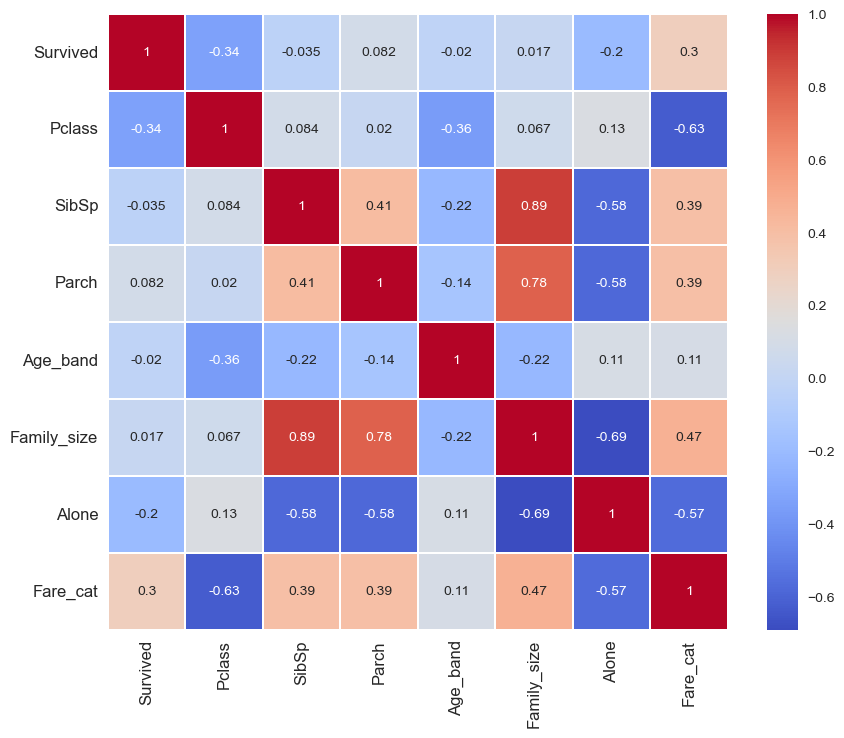

In [59]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidth=0.2, annot_kws={'size': 10})
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

가장 상관 관계가 높은 feature 는 Fare-cat 이고 Pclass 는 가장 상관관계가 반대인 것으로 나타난다.

### Category 변수의 One-Hot-Encoding

- sex, Embarked, Initial 변수를 one-hot-encoding

In [60]:
df = pd.get_dummies(df)
df.head()

,Survived,Pclass,SibSp,Parch,Age_band,Family_size,Alone,Fare_cat,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Initial_Miss,Initial_Mr,Initial_Mrs,Initial_Others
0,0,3,1,0,1,1,0,0,0,1,0,0,1,0,1,0,0
1,1,1,1,0,2,1,0,3,1,0,1,0,0,0,0,1,0
2,1,3,0,0,1,0,1,1,1,0,0,0,1,1,0,0,0
3,1,1,1,0,2,1,0,3,1,0,0,0,1,0,0,1,0
4,0,3,0,0,2,0,1,1,0,1,0,0,1,0,1,0,0


## Machine Learning Model 작성

## Train / Test dataset split

- 편향된 data 이므로 층화추출법 적용하여 train, test set 의 y 비율을 비슷하게 분리

In [61]:
X = df[df.columns[1:]]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 16), (178, 16), (712,), (178,))

## Standard Scaling

In [62]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

## Modeling

### Logistic Regression

In [63]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred= lr.predict(X_test)
print('Accuracy for Logistic Regression : ', accuracy_score(y_test, y_pred))
print('Precision Scroe : ', precision_score(y_test, y_pred))
print('Recall Scroe : ', recall_score(y_test, y_pred))

Accuracy for Logistic Regression :  0.7808988764044944
Precision Scroe :  0.7164179104477612
Recall Scroe :  0.7058823529411765


<AxesSubplot:>

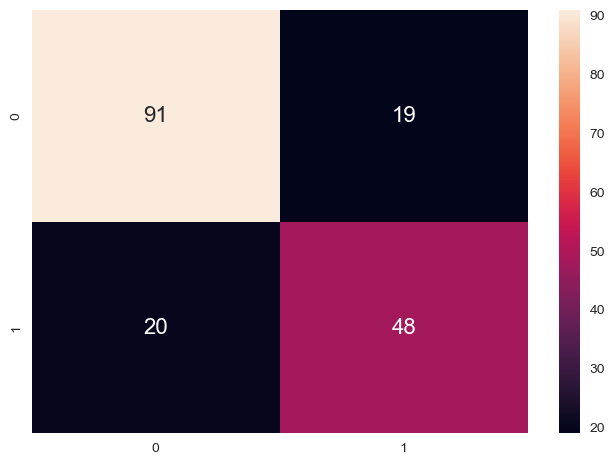

In [64]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='2.0f', annot_kws={'size':16})